[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/intel-analytics/BigDL/blob/main/python/chronos/colab-notebook/howto/how_to_export_torchscript_files.ipynb)

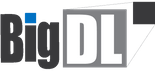

# Export the TorchScript model files to disk

## Introduction

When a forecaster is developed, we can save the forecaster and the whole forecasting pipeline (including data preprocessing, forecasting and data postprocessing) as torchscript by calling `export_torchscript_file`. In this guidance, **we demonstrate how to export these torchscript model files to disk** in detail.

We will take `TCNForecaster` and nyc_taxi dataset as an example in this guide.

## Setup

Before we begin, we need to install Chronos if it isn’t already available, we choose to use pytorch as deep learning backend.

In [ ]:
!pip install --pre --upgrade bigdl-chronos[pytorch]
# fix conflict with google colab
!pip uninstall -y torchtext

> 📝**Note**
> 
> - Although Chronos supports inferencing on a cluster, the method to export model files can only be used when forecaster is a non-distributed version.
> - Only pytorch backend deep learning forecasters support jit acceleration.

## Forecaster preparation

Before the exporting process, a forecaster should be created and trained. The training process is introduced in the previous guidance [Train forcaster on single node](https://bigdl.readthedocs.io/en/latest/doc/Chronos/Howto/how_to_train_forecaster_on_one_node.html) in detail, therefore we directly create and train a `TCNForecaster` based on the nyc taxi dataset.

In [ ]:
# scaler perparation
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# data preparation
def get_data():
    from bigdl.chronos.data import get_public_dataset
    

    # load the nyc taxi datset
    tsdata_train, tsdata_val, tsdata_test = get_public_dataset(name='nyc_taxi')

    # export test data to csv for future usage when deploying forecasting pipeline
    # make sure to set `index=False` to make the saved data have the same structure as original data
    tsdata_test.df.to_csv("deployment_data.csv", index=False)
    
    tsdata_train.scale(scaler, fit=True)

    return tsdata_train, tsdata_val, tsdata_test

# trained forecaster preparation
def get_trained_forecaster(train_data):
    from bigdl.chronos.forecaster import TCNForecaster
    # create a TCNForecaster
    forecaster = TCNForecaster(past_seq_len=48,
                               future_seq_len=1,
                               input_feature_num=1,
                               output_feature_num=1)
    
    # train the forecaster on the taining data
    forecaster.fit(train_data)
    return forecaster


## Export the torchscript model files

When a trained forecaster is ready and forecaster is a non-distributed version, we provide with `export_torchscript_file` method to export the torchscript model files to disk. There are 2 parameters you may want to specify: `dirname` is the location to save the torchscript files, if omitted, the model will be saved at "fp32_torchscript" directory under current directory, and `quantized_dirname` is the location to save the quantized torchscript model files. But the quantization of jit model is not supported yet, so we set it to `None`.

In [ ]:
from pathlib import Path

# get data for training and testing and validating
tsdata_train, tsdata_val, tsdata_test = get_data()
train_data = tsdata_train.to_torch_data_loader(roll=True, lookback=48, horizon=1)

# get a trained forecaster
forecaster = get_trained_forecaster(train_data)

# create a directory to save torchscript files
dirname = Path("torchscript_files")
dirname.mkdir(exist_ok=True)
ckpt_name = dirname / "fp32_torch_script"

# export the torchscript files
forecaster.export_torchscript_file(dirname=ckpt_name, quantized_dirname=None)


> 📝**Note**
> 
> - When `export_torchscript_file` is called, the forecaster will automatically build an jit session with default settings. So you can directly call this method without calling `predict_with_jit` first.

The files exported will be saved at `torchscript_files` directory. 

There are 2 files in each subdirectory:

- `nano_model_meta.yml`: meta information of the saved model checkpoint
- `ckpt.pth`: JIT model checkpoint for general use, describes model structure

You only need to take `ckpt.pth` file for futher usage.

## Export the whole forecasting pipeline

You could also save the whole forecasting pipeline to torchscript files, so it could be used without Python environment, and it's a great help when you want to deploy the forecasting pipeline in other languages like C++. We provide a parameter called `save_pipeline`, if it is set to `True`, the pipeline will be saved at "`dirname`/chronos_forecasting_pipeline.pt" by default, and you need to specify another 2 parameters (`tsdata` and `drop_dt_col`), please check [API doc](https://bigdl.readthedocs.io/en/latest/doc/PythonAPI/Chronos/forecasters.html#bigdl.chronos.forecaster.tcn_forecaster.TCNForecaster.export_torchscript_file) to know more about these parameters and current limitations of this feature. The following code shows how to export the forecasting pipeline to disk and how to use it during deployment.

In [ ]:
# export forecasting pipeline
forecaster.export_torchscript_file(dirname=ckpt_name,
                                   quantized_dirname=None,
                                   save_pipeline=True,
                                   tsdata=tsdata_train,
                                   drop_dt_col=True)

In [ ]:
# deployment example in Python

import pandas as pd
import torch

# load data from csv file
deployment_df = pd.read_csv("deployment_data.csv", parse_dates=["timestamp"])

# drop the datetime column because we specified `drop_dtcol=True` when exporting the pipeline
# now the data structure is same as data used in developing
deployment_df.drop(columns="timestamp", inplace=True)

# create input tensor
input_tensor = torch.from_numpy(deployment_df.values).type(torch.float64)

# load the forecasting pipeline
forecasting_pipeline_path = ckpt_name / "chronos_forecasting_pipeline.pt"
forecasting_pipeline = torch.jit.load(forecasting_pipeline_path)

# run pipeline
output_tensor = forecasting_pipeline.forward(input_tensor)


To verify the result, let's compare the output with the result using Chronos API. How to process data during deployment is shown in [How to process data in production environment](https://zhaojie-doc.readthedocs.io/en/export_forecasting_pipeline_howto/doc/Chronos/Howto/how_to_process_data_in_production_environment.html), you could refer to it for more detail.

In [ ]:
# compare the result with original pipeline using Chronos API

# deployment using Chronos API
from numpy.testing import assert_array_almost_equal
from bigdl.chronos.data import TSDataset
from sklearn.preprocessing import StandardScaler

test_df = pd.read_csv("deployment_data.csv", parse_dates=["timestamp"])
tsdata_test = TSDataset.from_pandas(test_df,
                                    dt_col="timestamp",
                                    target_col="value",
                                    repair=False,
                                    deploy_mode=True)

# preprocessing
# "scaler" should be the scaler used in development
tsdata_test.scale(scaler) \
           .roll(lookback=48, horizon=1)
input_data = tsdata_test.to_numpy()

# forecasting
forecasting_output = forecaster.predict_with_jit(input_data)

# postprocessing
postprocess_output = tsdata_test.unscale_numpy(forecasting_output)

# compare the results
assert_array_almost_equal(output_tensor.numpy(), postprocess_output)

### Deployment in C++

Since a more common case when deploying the pipeline is in C++, we provide an example code snip to show the core deployment workflow in C++ using libtorch APIs. You could refer to [installation guide](https://pytorch.org/cppdocs/installing.html) to install libtorch, and more information of APIs is available at [libtorch API doc](https://pytorch.org/cppdocs/api/library_root.html).

```C++
// core deployment workflow example in C++

#include <torch/torch.h>
#include <torch/script.h>

// Create input tensor from your data, you should implement this function.
// The data to create input tensor should have the same format as the data used in developing.
// If you sepcified drop_dt_col=True when exporting the pipeline, you should skip the
// datatime column here to keep the same structure as the developing data.
torch::Tensor input_tensor = create_input_tensor(data);

// load the forecasting pipeline
torch::jit::script::Module forecasting;
forecasting = torch::jit::load(forecasting_path);

// run pipeline
torch::Tensor output = forecasting.forward(input_tensor).toTensor();

```